#  TP 1: Neurosciences et inférence bayésienne

### 18 février 2024

### Par Samuel Fortin, Philippe Truchon et Benjamin Trudel

#### Fonctions générales

In [1]:
%%HTML
<!-- Grossit le texte dans les tables markdown -->
<style>
td,th {
  font-size: 16px
}
</style>

In [2]:
import fnmatch
import functools
import os

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.lines import Line2D
from scipy.special import gamma

sns.set_theme(style="ticks", palette="deep")

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False


# Créer une fonction à partir d'une fonction donnée qui permet de retourner un array numpy à partir de _difftrap (Provient de scipy.integrate)
def vectorize1(func):
    def vfunc(x):
        x = np.asarray(x)
        # call with first point to get output type
        y0 = func(x[0])
        n = len(x)
        dtype = getattr(y0, "dtype", type(y0))
        output = np.empty((n,), dtype=dtype)
        output[0] = y0
        for i in range(1, n):
            output[i] = func(x[i])
        return output

    return vfunc


# Intégration par méthode des trapèzes (Provient de scipy.integrate)
def _difftrap(function, interval, numtraps):
    numtosum = numtraps / 2
    h = float(interval[1] - interval[0]) / numtosum
    lox = interval[0] + 0.5 * h
    points = lox + h * np.arange(numtosum)
    s = np.sum(function(points), axis=0)
    return s


# Calcul les différents Rij pour la méthode de Romberg (Provient de scipy.integrate)
def _romberg_diff(b, c, k):
    tmp = 4.0**k
    return (tmp * c - b) / (tmp - 1.0)


# Fonction 'scipy.integrate.romberg' modifié pour les besoins du TP
def romberg_mod(function, a, b, tol=1.48e-8, rtol=1.48e-8, divmax=10):
    vfunc = vectorize1(function)
    n = 1
    interval = [a, b]
    intrange = b - a
    ordsum = _difftrap(vfunc, interval, n)
    result = intrange * ordsum
    resmat = [[result]]
    err = np.inf
    lerr = []
    last_row = resmat[0]
    for i in range(1, divmax + 1):
        n *= 2
        ordsum += _difftrap(vfunc, interval, n)
        row = [intrange * ordsum / n]
        for k in range(i):
            row.append(_romberg_diff(last_row[k], row[k], k + 1))
        result = row[i]
        lastresult = last_row[i - 1]
        resmat.append(row)
        err = abs(result - lastresult)
        lerr.append(err)
        if i > 4:
            pass
            if err < tol or err < rtol * abs(result):
                break
        last_row = row

    return (vfunc, interval, resmat, result, lerr)


# Liste les noms de fichier d'un dossier
def listNameOfFiles(directory: str, extension="txt"):
    found_files = []
    for file in os.listdir(directory):
        if fnmatch.fnmatch(file, f"*.{extension}"):
            found_files.append(file)
    return found_files


# Lis et crée une matrice numpy à partir de chemin d'un fichier texte
def readTXT(path: str):
    fich = open(path, "r")
    fich_str = list(fich)
    fich.close()
    x = []
    for i in fich_str:
        elem_str = i.replace("\n", "")
        x.append(float(elem_str))
    return np.array(x)


# Intégration par méthode de Simpson 'nested' et récursive dans le cas d'instabilité créer par le 'nesting'.
# Bonne pour trouvé le chemin le plus rapide, mais une fois trouvé plus efficace de trouvé le résultat avec Simpson simple
def nested_simpson(f: callable, a: float, b: float, N: int):
    if N < 3:
        return "La valeur minimale est 3, car la méthode de simpson nécessite 3 points par approximation"
    N0 = N
    h0 = (b - a) / N
    even = np.linspace(2, N - 2, int((N - 2) / 2), dtype=int)
    odd = np.linspace(1, N - 1, int((N - 1) / 2), dtype=int)
    S0 = (f(a) + f(b) + 2 * np.sum(list(map(f, a + even * h0)))) / 3
    T0 = 2 / 3 * np.sum(list(map(f, a + odd * h0)))
    res0 = h0 * (S0 + 2 * T0)
    err = np.inf
    lres = [res0]
    lerr = [err]
    while err > 1e-15:
        N = N * 2
        hi = (b - a) / N
        Si = S0 + T0
        Ti = 2 / 3 * np.sum(list(map(f, a + odd * hi)))
        res = hi * (Si + 2 * Ti)
        err = (abs((res - res0)) / 3) / res
        if err > lerr[-1]:
            tes = nested_simpson(f, a, b, int(N0 + 1))
            if tes:
                return tes

        lres.append(res)
        lerr.append(err)
        S0 = Si
        T0 = Ti
        res0 = res
    return lres, lerr, N0, a, b


# Intégration par méthode de Simpson
def simple_simpson(f: callable, a: float, b: float, N: int):
    if N < 3:
        return "La valeur minimale est 3, car la méthode de simpson nécessite 3 points par approximation"
    h0 = (b - a) / N
    even = np.linspace(2, N - 2, int((N - 2) / 2), dtype=int)
    odd = np.linspace(1, N - 1, int((N - 1) / 2), dtype=int)
    res = (
        (
            f(a)
            + f(b)
            + 2 * np.sum(list(map(f, a + even * h0)))
            + 4 * np.sum(list(map(f, a + odd * h0)))
        )
        / 3
        * h0
    )
    return N, res


# Intégrale par méthode de simpson doublant N jusqu'à atteindre la précision machine
def auto_simple_simpson(f: callable, a: float, b: float):
    xs = 2 ** np.arange(3, 20)  # Valeur max pour que ça soit pas trop long
    xr = []
    yr = [np.inf]
    err = []
    for k in xs:
        x, y = simple_simpson(f, a, b, k)
        xr.append(x)
        yr.append(y)
        err.append(abs(y - yr[-2]) / y / 3)
        if abs(y - yr[-2]) / y < 1e-15:
            return yr, err, xr[0], a, b
    return f"Précison machine non atteinte pour {xr[-1]} itérations"


# Définition de pi(lambda) pour une loi Gamma
def pi_lambda(Lambda: float, alpha: int, beta: float):
    return (
        1
        / gamma(alpha)
        * Lambda ** (alpha - 1)
        * np.exp(-beta * Lambda)
        * beta ** (alpha)
    )


# Définition de la loi de Poisson
def poisson(x, Lambda):
    return Lambda * np.exp(-Lambda * x)


# Définition ddu théorème de Bayes
def bayes(Lambda, data):
    x = np.sort(np.ediff1d(data))
    return pi_lambda(Lambda, 2, 0.25) * np.prod(poisson(x, Lambda))


# Définition de la loi a posteriori
def posteriori(Lambda, data):
    return Lambda * bayes(Lambda, data)


# Montre les résultats des itérations de la méthode de Romberg
def show_Romberg(test):
    interval = test[1]
    resmat = test[2]
    err = test[4]
    print("Méthode de Romberg:\n")
    print("De lambda = ", interval)
    print("")
    print("%6s %9s " % ("N", "h"))
    for i in range(1, len(resmat) - 1):
        print("%6d %9f" % (2**i, (interval[1] - interval[0]) / (2.0**i)), end=" ")

        print("Résultat = %.15E" % (resmat[i][-1]), end=" ")
        print("Erreur = %.15E" % err[i], end=" ")
        print("Erreur relative = %.15E" % (err[i] / resmat[i][-1]), end=" ")
        print("")
    print("")
    print("Le résultat final est", "%.15E" % (resmat[i][-1]), end=" ")
    print("après", 2 ** (len(resmat) - 1) + 1, "évaluations de la fonction.")
    print("")


# Montre les résultats des itérations de la méthode de Simpson
def show_Simpson(res):
    interval = [res[-2], res[-1]]
    r = res[0]
    err = res[1]
    print("Méthode de Simpson:\n")
    print("De lambda = ", interval)
    print("")
    print("%6s %9s " % ("N", "h"))
    for i in range(1, len(r) - 1):
        print(
            "%6d %9f" % (res[2] * i, (interval[1] - interval[0]) / (res[2] * i)),
            end=" ",
        )
        print("Résultat = %.15E" % (r[i]), end=" ")
        print("Erreur relative = %.15E" % (err[i]), end=" ")
        print("")
    print("")
    print("Le résultat final est", "%.15E" % (r[-1]), end=" ")
    print("avec N = ", res[2] * i, ".")
    print("")


# Pour s'assurer de garder le bon nombre sig figs
def round_significant_digits(x, precision=4):
    string = np.format_float_positional(
        x, unique=False, fractional=False, trim="k", precision=precision
    )
    return float(string)


round_significant_digits_vectorized = np.vectorize(
    round_significant_digits, otypes=[object]
)

### Questions:

#### 1.

Trouvez analytiquement π(λ|X = x) et déduisez la valeur de f(x). Indice : trouvez une fonction
g(λ) proportionnelle à la loi a posteriori, ce qui vous permettra de retrouver la même forme que
la loi a priori π(λ). Cette loi a priori π(λ) est conjuguée à la vraisemblanc

La fonction de normalisation f(x) est l'intégrale proportionelle de la loi à postériori:

$f(x) = \int_0^\infty \frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}d\lambda$

Posons k = $\beta+\sum_{i=1}^{T}x_i$

$f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \int_0^\infty \lambda^{T+\alpha-1}e^{-\lambda k}d\lambda$

$f(x) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} \Gamma(\alpha+T)k^{-(\alpha+T)}$

donc, 

$\pi(\lambda|X=x) = \frac{\frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\frac{\beta^{\alpha}}{\Gamma(\alpha)}\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}} $

$\pi(\lambda|X=x) = \frac{\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}} $

#### 2.

Évaluez analytiquement l’espérance a priori $λ_0 := E[Λ] = \int_0^∞ π(λ)dλ$  et l’espérance a posteriori

$\hat{\lambda}$. Rappel : $Γ(z) = \int_0^∞ t^{z−1} e^{−t} dt $ et $Γ(z + 1) = zΓ(z)$.
 

2.1

$\lambda_0 = \int_0^\infty \frac{\beta^{\alpha}}{\Gamma(\alpha)}\lambda^{\alpha}e^{-\beta\lambda}d\lambda$

où $\Gamma(\alpha) = \int_0^\infty t^{\alpha-1}e^{^t}dt$ 

Si on remplace t par $\beta\lambda$, on obtient:

$\lambda_0 = \frac{\beta^{\alpha}\int_0^\infty \lambda^{\alpha}e^{-\beta\lambda}d\lambda}{\beta^{\alpha}\int_0^\infty \lambda^{\alpha-1}e^{-\beta\lambda}d\lambda} = \frac{\Gamma(\alpha +1)\beta^{-(\alpha+1)}}{\Gamma(\alpha)\beta^{-(\alpha)}} = \frac{\alpha \Gamma(\alpha)}{\Gamma(\alpha)\beta}$

Ainsi,

$\lambda_0 = \frac{\alpha}{\beta}$





2.2

$\hat{\lambda} = \int_0^\infty \lambda\bigg(\pi(\lambda|X=x)\bigg)d\lambda$

$\hat{\lambda} = \int_0^\infty \lambda\bigg(\frac{\lambda^{T+\alpha-1}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}}{\Gamma(\alpha+T)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T)}}\bigg)d\lambda $

Le dénominateur est indépendant de $\lambda$ et l'intégration du numérateur est comme suit:

$\int_0^\infty \lambda^{T+\alpha}e^{-\lambda(\beta+\sum_{i=1}^{T}x_i)}d\lambda = \Gamma(\alpha+T+1)(\beta+\sum_{i=1}^{T}x_i)^{-(\alpha+T+1)}$

Ainsi,

$\hat{\lambda} = \frac{(T+\alpha)\Gamma(T+\alpha)}{\Gamma(T+\alpha)(\beta+\sum_{i=1}^{T}x_i)} = \frac{(T+\alpha)}{(\beta+\sum_{i=1}^{T}x_i)}$

#### 3.

Voir la section 'Fonctions générales'

#### 4.

En inférence bayésienne, il n’est généralement pas possible d’évaluer analytiquement f(x) et
l’équation (5). En posant que α = 2 et β = 1/4, évaluez numériquement f(x) et $\hat{\lambda}$ pour chaque
série de données x en utilisant la méthode de Simpson et la méthode de Romberg. Considérez
que λ = 200 est suffisamment grand dans les bornes d’intégration 1
. Vous pouvez utiliser la
fonction Gamma de scipy.


Pour la méthode de Simpson le code ci-dessous est utilisé. Le code trouve la liste de fichier texte du dossier contenant le script, puis boucle sur tous les fichiers trouvés. Par la suite, pour chaque fichier de donnée, le théorème de Bayes est appliqué à l'aide de la méthode d'intégration de Simpson et les résultats sont affichés. Finalement, la <i> loi a posteriori </i> est évaluée avec la méthode de Simpson et le résultat de $\hat{\lambda}$ est affiché.

In [3]:
%%time
path = os.path.abspath("")
files_name = listNameOfFiles(path)

for nb, name in enumerate(files_name):
    data_time = readTXT(path + "/" + name)

    bayes_partial = functools.partial(bayes, data=data_time)
    posteriori_partial = functools.partial(posteriori, data=data_time)

    res = auto_simple_simpson(bayes_partial, 0, 200)
    fx_simpson = res[0][-1]
    show_Simpson(res)

    print("Résultat méthode Simpson = {:#.16g}".format(fx_simpson))

    lct = auto_simple_simpson(posteriori_partial, 0, 200)

    lc = lct[0][-1] / fx_simpson

    print("Lambda chapeau_{:} = {:#.16g} \n".format(nb, lc))  # lambda """

Méthode de Simpson:

De lambda =  [0, 200]

     N         h 
     8 25.000000 Résultat = 1.234989785741314E+16 Erreur relative = 3.333333333333333E-01 
    16 12.500000 Résultat = 3.194198560869025E+46 Erreur relative = 2.260417206537776E-01 
    24  8.333333 Résultat = 9.923728677683410E+46 Erreur relative = 3.276331488950969E-01 
    32  6.250000 Résultat = 5.803162327588243E+48 Erreur relative = 2.027626630453088E-01 
    40  5.000000 Résultat = 3.608285560042059E+48 Erreur relative = 1.854448706609055E-02 
    48  4.166667 Résultat = 3.820852827568921E+48 Erreur relative = 4.700087651420934E-04 
    56  3.571429 Résultat = 3.815472910435720E+48 Erreur relative = 8.397691993355448E-11 
    64  3.125000 Résultat = 3.815472911396955E+48 Erreur relative = 1.134043970238754E-16 

Le résultat final est 3.815472911396956E+48 avec N =  64 .

Résultat méthode Simpson = 3.815472911396956e+48
Lambda chapeau_0 = 8.879626693245140 

Méthode de Simpson:

De lambda =  [0, 200]

     N         h 

Maintenant, pour la méthode de Romberg:

In [4]:
%%time
path = os.path.abspath("")
files_name = listNameOfFiles(path)

for nb, name in enumerate(files_name):
    data_time = readTXT(path + "/" + name)

    bayes_partial = functools.partial(bayes, data=data_time)
    posteriori_partial = functools.partial(posteriori, data=data_time)

    test = romberg_mod(bayes_partial, 0, 200, tol=1e-16, rtol=1e-15, divmax=20)
    fx_romberg = test[2][-1][-1]
    show_Romberg(test)

    print("Résultat méthode Romberg = {:#.16g}".format(fx_romberg))

    lct_romberg = romberg_mod(
        posteriori_partial, 0, 200, tol=1e-15, rtol=1e-15, divmax=20
    )
    lc =lct_romberg[2][-1][-1] / fx_romberg

    print("Lambda chapeau_{:} = {:#.16g} \n".format(nb, lc))  # lambda """

Méthode de Romberg:

De lambda =  [0, 200]

     N         h 
     2 100.000000 Résultat = 4.089910472079163E-285 Erreur = 6.213773608781261E-75 Erreur relative = 1.519293307567782E+210 
     4 50.000000 Résultat = 6.213773608781261E-75 Erreur = 1.338232318094291E+16 Erreur relative = 2.153654771398673E+90 
     8 25.000000 Résultat = 1.338232318094291E+16 Erreur = 3.474800238781822E+46 Erreur relative = 2.596559798921991E+30 
    16 12.500000 Résultat = 3.474800238781822E+46 Erreur = 7.042536350602424E+46 Erreur relative = 2.026745673607804E+00 
    32  6.250000 Résultat = 1.051733658938425E+47 Erreur = 6.206544817789521E+48 Erreur relative = 5.901251486097863E+01 
    64  3.125000 Résultat = 6.311718183683365E+48 Erreur = 2.907894311465100E+48 Erreur relative = 4.607135849288068E-01 
   128  1.562500 Résultat = 3.403823872218265E+48 Erreur = 4.393431918942072E+47 Erreur relative = 1.290734210662575E-01 
   256  0.781250 Résultat = 3.843167064112472E+48 Erreur = 2.850786585902523E+46 

#### Tableau récapitulatif des résultats pour $\hat{\lambda}$ et f(x) obtenus numériquement

</style>
|  | Méthode de Simpson || Méthode de Romberg ||
|---|---|---|---|---|
|  | $\hat{\lambda}$| f(x) | $\hat{\lambda}$| f(x) |
| activite_temps_0 | 8.87962669324514**0** | 3.815472911396956×10⁴⁸ | 8.87962669324514**1** | 3.815472911396956×10⁴⁸ |
| activite_temps_1 | 21.07028444884006| 2.28331615273580**8**×10⁸⁵ | 21.07028444884006 | 2.28331615273580**9**×10⁸⁵ |
| activite_temps_2 | 33.9135550403156**0** | 4.125267575201229×10¹⁰⁵ |33.9135550403156**1**| 4.125267575201229×10¹⁰⁵ |

On peut remarquer que les deux méthodes d'intégration peuvent être poussées à la précison machine dans un délai résonnable pour ce type de données. En poussant ces méthodes à cette précision, les même résultats sont obtenus, sauf pour le dernier chiffre significatif dans certains cas indiqué en **gras** dans le tableau ci-dessus. Ceci peut s'expliquer par le fait que la précision machine est environ $x\times 10^{-16}$.

#### 5.

En comparant à votre solution analytique, tracez l’erreur sur f(x) et $\hat{\lambda}$ engendrée par vos deux
méthodes d’intégration en fonction du nombre de tranches pour le jeux de données de votre
choix.

Valeur analytique de $\hat{\lambda} = 33.91355504031561$
Valeur analytique de $F(x)_2 = 4.1252675752012599e105$ 

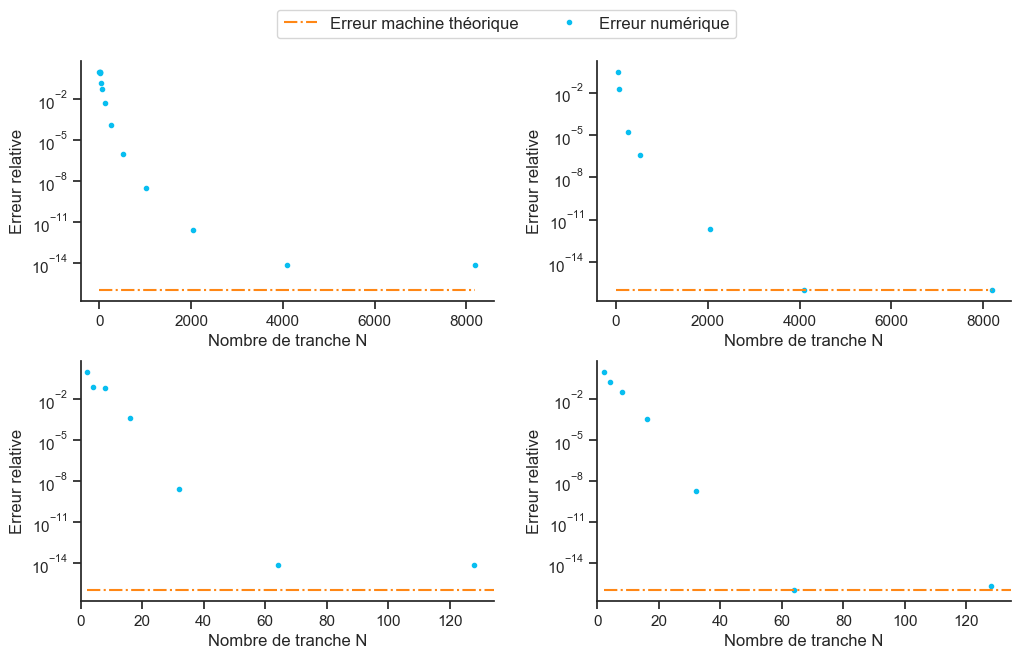

In [5]:
fx2 = 4.1252675752012599e105
lc2 = 33.91355504031561
y0 = []
for i in test[2]:
    y0.append(i[-1])
y1 = []
for i in lct_romberg[2]:
    y1.append(i[-1])

y2 = res[0][1:]
y3 = lct[0][1:]

x0 = 2 ** np.arange(1, len(y0) + 1)
x1 = 2 ** np.arange(1, len(y1) + 1)
x2 = 2 ** np.arange(1, len(y2) + 1)
x3 = 2 ** np.arange(1, len(y3) + 1)

yr0 = abs(np.array(y0, dtype=object) - fx2) / fx2
# L'ajout est pour régler un problème de sig figs avec ce cas spécifique (trop de sigs générer par la division)
yr1 = (
    round_significant_digits_vectorized(
        abs((np.array(y1, dtype=object) / fx_romberg)), precision=16
    )
    - lc2
) / lc2
ys0 = abs(np.array(y2, dtype=object) - fx2) / fx2
ys1 = (abs((np.array(y3, dtype=object) / fx_simpson) - lc2)) / lc2

yr1[-2] = 1e-16  # On obtient zéro qui ne parait pas sur un graph log
yr1[-1] = 1e-16  # On obtient zéro qui ne parait pas sur un graph log
ys1[-2] = 1e-16  # On obtient zéro qui ne parait pas sur un graph log

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 6))
plt.subplots_adjust(bottom=0, top=0.9, wspace=0.25, hspace=0.25)
for i in ax:
    for j in i:
        j.set_yscale("log")
        # j.set_xscale("log")
        j.set_xlabel("Nombre de tranche N")
        j.set_ylabel("Erreur relative")
ax[0][0].plot(x0, yr0, marker=".", color="#08BEF0", linestyle="None")  # f(x) romberg
ax[0][0].plot([x0[0], x0[-1]], [1e-16, 1e-16], color="#FF8715", linestyle="-.")
ax[0][1].plot(x1, yr1, marker=".", color="#08BEF0", linestyle="None")  # lambda romberg
ax[0][1].plot([x1[0], x1[-1]], [1e-16, 1e-16], color="#FF8715", linestyle="-.")

ax[1][0].set_xlim([0, x2[-1] * 1.05])
ax[1][1].set_xlim([0, x3[-1] * 1.05])
ax[1][0].plot(x2, ys0, marker=".", color="#08BEF0", linestyle="None")  # f(x) simpson
ax[1][0].plot([x0[0], x0[-1]], [1e-16, 1e-16], color="#FF8715", linestyle="-.")
ax[1][1].plot(x3, ys1, marker=".", color="#08BEF0", linestyle="None")  # lambda simpson
ax[1][1].plot([x0[0], x0[-1]], [1e-16, 1e-16], color="#FF8715", linestyle="-.")
legend_elements = [
    Line2D([], [], color="#FF8715", label="Erreur machine théorique", linestyle="-."),
    Line2D(
        [], [], color="#08BEF0", label="Erreur numérique", linestyle="None", marker="."
    ),
]
fig.legend(
    handles=legend_elements,
    fontsize=12,
    loc=9,
    bbox_to_anchor=(0.23, 0.5, 0.5, 0.5),
    ncols=2,
)
plt.show()

Les valeurs analytiques et numériques de f(x) sont différente car on intègre de 0 à 200 en numérique comparativement à l'intégration de 0 à $\infty$ de la fonction gamma en analytique. Ce qui explique donc la valeur numérique légèrement plus petite. Cette erreur est compensée en évaluant $\hat\lambda$, car la deuxième intégrale crée une nouvelle erreur similaire et les deux semblent s'annuler ensemble.

#### 6.

Quels sont les défis reliés à l’intégration numérique de l’évidence f(x) en inférence bayésienne ?

En inférence bayésienne, l'intégration numérique de l'évidence s'avère compliquée à cause du grand nombre de calcul nécessaire à l'intégration de f(x) et la division de deux nombre aux ordres de grandeurs très différents lors du calcul de $\lambda_c$. En effet, tant avec la méthode de simpson qu'avec la méthode de romberg, on additionne un grand nombre de valeurs ayant toutes leurs propres incertitudes. Leurs erreurs s'additionnent donc tout autant.

#### 7.

Tracez un histogramme des fréquences relatives des écarts entre les impulsions. Tracez également
la loi du modèle a priori f($x_i$
|Λ = $λ_0$) et celle ajustée f($x_i$
|Λ = $\hat{\lambda}$).

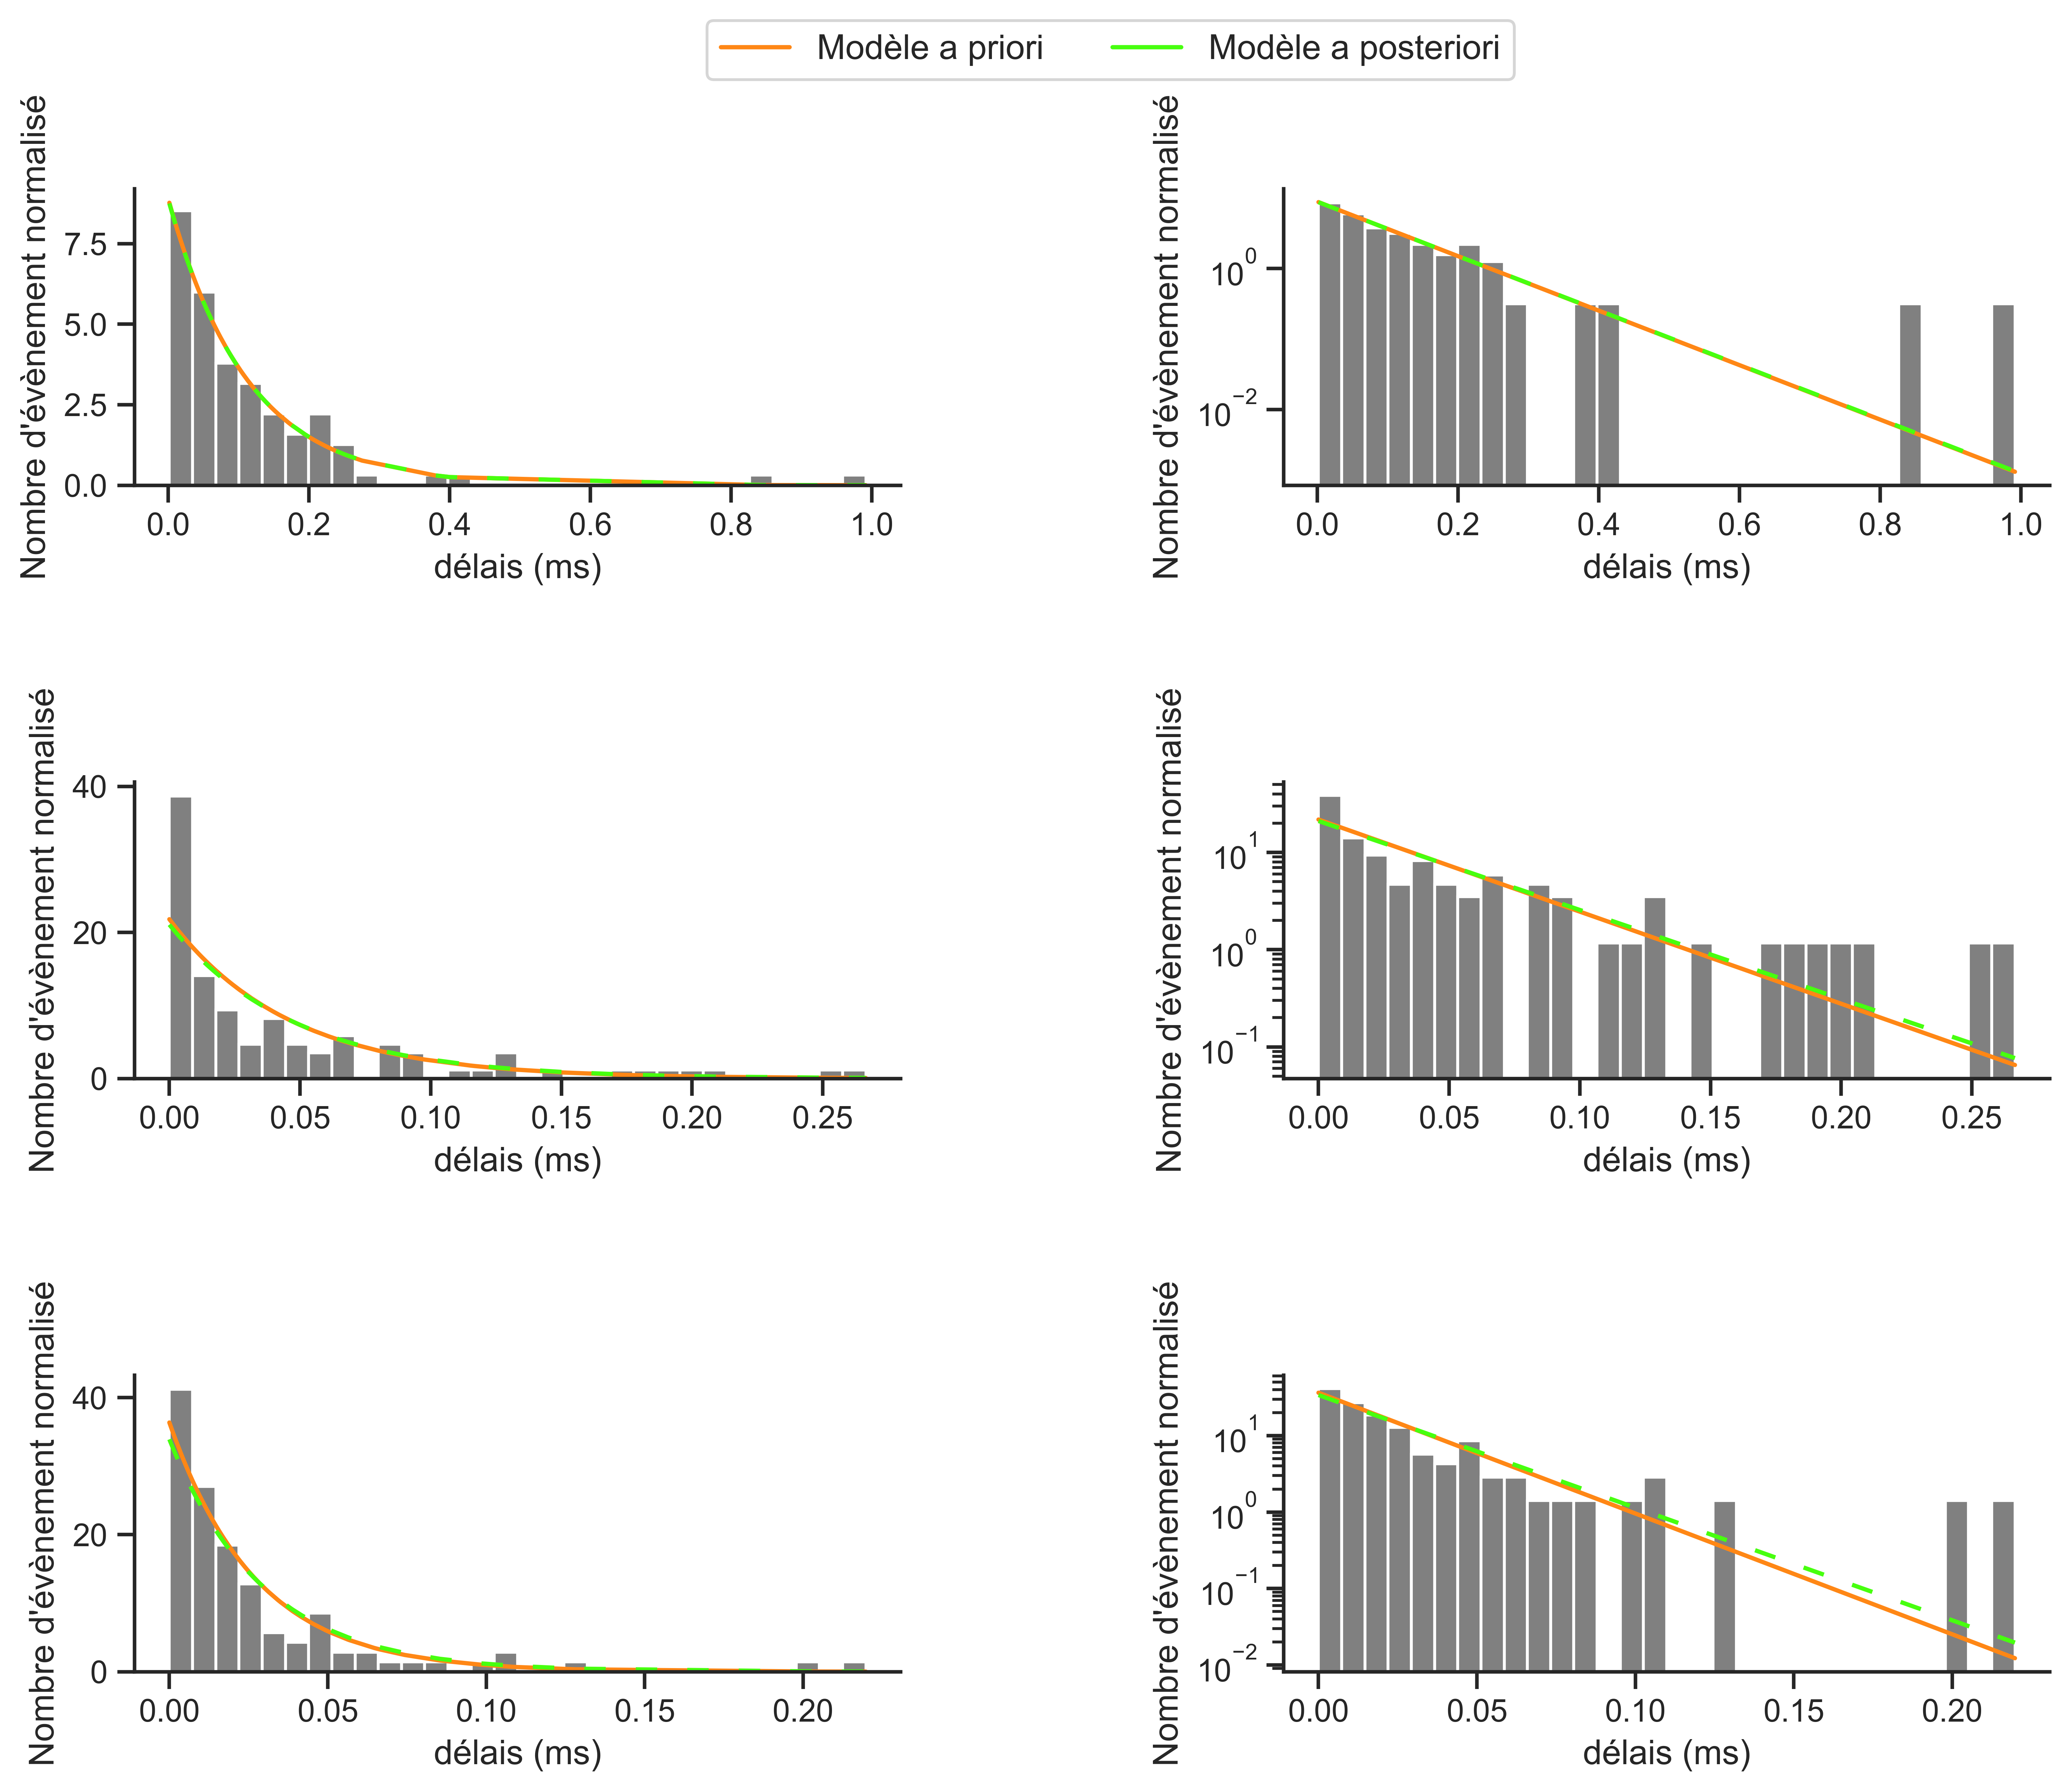

In [6]:
path = os.path.abspath("")
files_name = listNameOfFiles(path)

t0 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[0])))
t1 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[1])))
t2 = np.sort(np.ediff1d(readTXT(path + "/" + files_name[2])))

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 9), dpi=600)

for i in ax:
    for j in i:
        j.set_xlabel("délais (ms)")
        j.set_ylabel("Nombre d'évènement normalisé")
for i in ax[:, 1]:
    i.set_yscale("log")
plt.subplots_adjust(bottom=0.9, top=1.7, wspace=0.5, hspace=1)
for i in range(2):
    ax[0][i].hist(t0, bins=30, color="gray", density=True)
    ax[0][i].plot(
        t0, poisson(t0, 1 / np.mean(t0)), color="#FF8715", label="Modèle a priori"
    )
    ax[0][i].plot(
        t0,
        poisson(t0, 8.87962669324514),
        linestyle=(0, (5, 7)),
        color="#47FF0F",
        label="Modèle a posteriori",
    )

    ax[1][i].hist(t1, bins=30, color="gray", density=True)
    ax[1][i].plot(
        t1, poisson(t1, 1 / np.mean(t1)), color="#FF8715", label="Modèle a priori"
    )
    ax[1][i].plot(
        t1,
        poisson(t1, 21.07028444884007),
        linestyle=(0, (5, 7)),
        color="#47FF0F",
        label="Modèle a posteriori",
    )

    ax[2][i].hist(t2, bins=30, color="gray", density=True)
    ax[2][i].plot(
        t2, poisson(t2, 1 / np.mean(t2)), color="#FF8715", label="Modèle a priori"
    )
    ax[2][i].plot(
        t2,
        poisson(t2, 33.91355504031561),
        linestyle=(0, (5, 7)),
        color="#47FF0F",
        label="Modèle a posteriori",
    )

legend_elements = [
    Line2D([], [], color="#FF8715", label="Modèle a priori"),
    Line2D([], [], color="#47FF0F", label="Modèle a posteriori"),
]
fig.legend(
    handles=legend_elements,
    fontsize=12,
    loc=9,
    bbox_to_anchor=(0.27, 1.3, 0.5, 0.5),
    ncols=2,
)
plt.show()

#### 8.

Avec vos connaissances sur le processus de Poisson et l’inférence bayésienne, que pouvez-vous
conclure du comportement de chaque neurone grâce à vos résultats ? Les processus sont-ils
poissonien dans tous les cas ? Vous pouvez soutenir votre réponse en utilisant le fait que
− log(f(x)) croît en fonction d’un modèle qui décrit de mieux en mieux les données.